In [22]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

fig_width_pt = 3*246.0  # Get this from LaTeX using \showthe\columnwidth
inches_per_pt = 1.0/72.27               # Convert pt to inch
golden_mean = (np.sqrt(5)-1.0)/2.0         # Aesthetic ratio
fig_width = fig_width_pt*inches_per_pt  # width in inches
fig_height = fig_width*golden_mean      # height in inches
fig_size =  [fig_width,fig_height]

params = { 'axes.labelsize': 24,
          'font.family': 'serif',
          'font.serif': 'Computer Modern Raman',
          'font.size': 24,
          'legend.fontsize': 20,
          'xtick.labelsize': 24,
          'ytick.labelsize': 24,
          'axes.grid' : False,
          'text.usetex': True,
          'savefig.dpi' : 100,
          'lines.markersize' : 14,
          'figure.figsize': fig_size}

mpl.rcParams.update(params)

In [23]:
from pycbc.catalog import Merger
from pycbc.psd import interpolate, inverse_spectrum_truncation
from pycbc.frame import read_frame
from pycbc import frame
from pycbc.filter import highpass, resample_to_delta_t,matched_filter,sigma
from pycbc.waveform import get_td_waveform
from pycbc.types import TimeSeries

In [24]:
strain = frame.query_and_read_frame("H1_LOSC_16_V1", "H1:GWOSC-16KHZ_R1_STRAIN", 1126259462.43+100, 1126259462.43+100 + 32)

In [25]:
plt.plot(strain.sample_times,strain)

In [26]:
strain = resample_to_delta_t(highpass(strain, 15.0), 1.0/2048)
conditioned = strain.crop(2, 2)

In [27]:
plt.plot(conditioned.sample_times,conditioned)

In [28]:
# We use 4 second samles of our time series in Welch method.
psd = conditioned.psd(4)
psd = interpolate(psd, conditioned.delta_f)
psd = inverse_spectrum_truncation(psd, int(4 * conditioned.sample_rate),
                                  low_frequency_cutoff=15)

In [29]:
m = 36 # Solar masses
hp, hc = get_td_waveform(approximant="SEOBNRv4_opt",
                     mass1=m,
                     mass2=m,
                     delta_t=conditioned.delta_t,
                     f_lower=20)

# We will resize the vector to match our data
hp.resize(len(conditioned))

In [30]:
template = hp.cyclic_time_shift(hp.start_time)

In [31]:
idx = len(conditioned.sample_times)
middle_time = conditioned.sample_times[idx//2]

In [32]:
middle_time

1126259578.43

In [33]:
a = 4e-19
s = 0.01
pulse = a*np.exp(-(conditioned.sample_times-middle_time)**2/s**2)
pulse_ts = TimeSeries(pulse,delta_t=conditioned.delta_t,epoch=conditioned.start_time)

In [35]:
%matplotlib inline

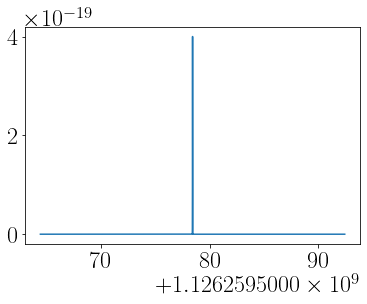

In [36]:
plt.plot(pulse_ts.sample_times,pulse_ts)

In [37]:
conditioned = conditioned + pulse_ts

Text(0, 0.5, 'strain')

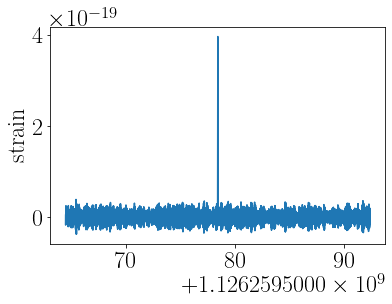

In [45]:
plt.plot(conditioned.sample_times,conditioned)
plt.ylabel('strain')

In [39]:
snr = matched_filter(template, conditioned,
                     psd=psd, low_frequency_cutoff=20)

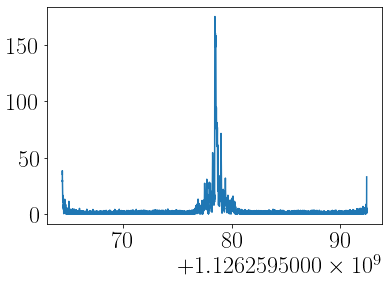

In [40]:
plt.plot(snr.sample_times,abs(snr))

In [41]:
snr = snr.crop(4 + 4, 4)

Text(0, 0.5, 'SNR')

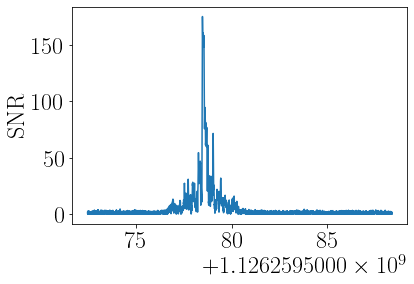

In [43]:
plt.plot(snr.sample_times,abs(snr))
plt.ylabel('SNR')

In [18]:
peak = abs(snr).numpy().argmax()
snrp = snr[peak]
peaktime = snr.sample_times[peak]

In [19]:
dt = peaktime - conditioned.start_time
aligned = template.cyclic_time_shift(dt)
# scale the template so that it would have SNR 1 in this data
aligned /= sigma(aligned, psd=psd, low_frequency_cutoff=20.0)
# Scale the template amplitude and phase to the peak value
aligned = (aligned.to_frequencyseries() * snrp).to_timeseries()
aligned.start_time = conditioned.start_time
tapered = aligned.highpass_fir(30, 512, remove_corrupted=False)
white_template = (tapered.to_frequencyseries() / psd**0.5).to_timeseries()
white_template = white_template.highpass_fir(30, 512).lowpass_fir(300, 512)

In [20]:
white_data = (conditioned.to_frequencyseries() / psd**0.5).to_timeseries()
white_data = white_data.highpass_fir(30., 512).lowpass_fir(300, 512)

In [21]:
i=0
for idx in range(len(snr.sample_times))[peak-600:peak+100:2]:
    i=i+1
    time = snr.sample_times[idx]
    snr_now = snr.time_slice(time-.2,time)
    white_data_now = white_data.time_slice(time-.2, time+.1)
    white_template_now = white_template.time_slice(peaktime-.2, peaktime+.1)
    
    fig, (ax1, ax2) = plt.subplots(nrows=2, sharex=True)
#    ax1=plt.subplot(211)
    
    ax1.plot(snr_now.sample_times,abs(snr_now))
    ax1.set_xlim(time-.2,time+.1)
    #ax1.set_ylim(0,20)
    ax1.set_ylabel('SNR')
    ax1.set_title('manually added glitch')
    #plt.xlim(time-1,time+1)
    
#    ax2 = plt.subplot(212,sharex=ax1)
    ax2.plot(white_data_now.sample_times, white_data_now, label="Data")
    ax2.plot(white_template_now.sample_times-(peaktime-time), white_template_now, label="Template")
    ax2.set_xlabel('time')
    ax2.set_ylabel('whitened strain')
    ax2.set_xlim(time-.2,time+.1)
    ax2.legend(loc='upper left')
    plt.savefig('glitch/%04d.png' % i)
    print(i)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


/work/yifan.wang/virtualenv/sgwb/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  if __name__ == '__main__':


20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277
278
279
280
281
282
283
284
285
286
287
288
289
